This notebook just fits the HST/WFC3 G141 broadband light curve, mainly to get a good starting value for the systematic parameters when running a larger MCMC with other data.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Loading in the broadband light curve
bbdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/Transit_Broad_Visit3_NoFirst.npz')
times = bbdata['time']
rawfluxes = bbdata['flux']
rawerrors = bbdata['error']
scandirs = bbdata['scandir']

# normalizing the flux and flux error values
fluxes, errors = np.copy(rawfluxes), np.copy(rawerrors)
sd1_idxs, sd0_idxs = np.where(scandirs == 1.)[0], np.where(scandirs == 0.)[0]
normval1, normval0 = np.median(rawfluxes[sd1_idxs]), np.median(rawfluxes[sd0_idxs])
    
fluxes[sd1_idxs] /= normval1
errors[sd1_idxs] /= normval1
fluxes[sd0_idxs] /= normval0
errors[sd0_idxs] /= normval0

# creating the relative time arrays
t_visit = times - times[0]  # time since start of visit [day]

orbit_ends = np.array([17, 34, 51]) # indeces separing each orbit (note: orbit1 excluded)
orbit2times = times[:orbit_ends[0]]
orbit3times = times[orbit_ends[0] : orbit_ends[1]]
orbit4times = times[orbit_ends[1] : orbit_ends[2]]
# From above, compute time since beginning of orbit for each
tinorbit2 = orbit2times - orbit2times[0]
tinorbit3 = orbit3times - orbit3times[0]
tinorbit4 = orbit4times - orbit4times[0]
t_orbit = np.concatenate((tinorbit2, tinorbit3, tinorbit4))

In [23]:
print('Timing Info -----------------------')
print('Time of first scan: ', times[0])
print('Time of last scan: ', times[-1])
print('Number of scans total:', len(times))
print('N scans per orbit: ', len(orbit2times), len(orbit3times), len(orbit4times))
print('Avg. orbit duration [min]: ', np.mean([(orbit2times[-1]-orbit2times[0]),
                                       (orbit3times[-1]-orbit3times[0]),
                                       (orbit4times[-1]-orbit4times[0])
                                       ])*24.*60.)
print('Data Info ---------------------------')
mean_err, sd_err = norm.fit(errors)
print('Mean flux uncertainty [ppm]: ', mean_err*1.e6)
print('Scatter in flux uncertainty [ppm]: ', sd_err*1.e6)

Timing Info -----------------------
Time of first scan:  2458799.8198642572
Time of last scan:  2458799.9847369217
Number of scans total: 51
N scans per orbit:  17 17 17
Avg. orbit duration [min]:  40.53322948515415
Data Info ---------------------------
Mean flux uncertainty [ppm]:  46.320335056486876
Scatter in flux uncertainty [ppm]:  0.11342163698902125


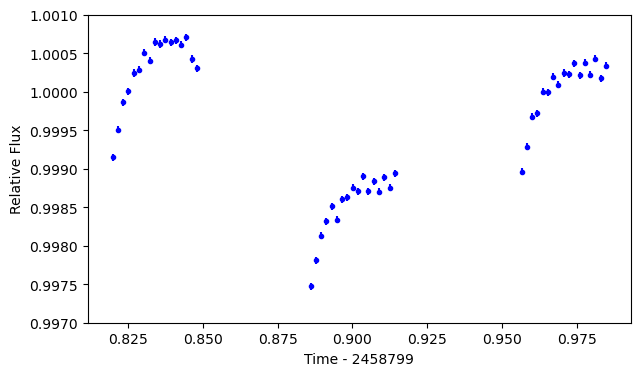

In [14]:
fig, ax = plt.subplots(figsize=(7,4))
ax.errorbar(times-2458799, fluxes, errors, ls='None', marker='o', c='blue', ms=3)
ax.set(xlabel='Time - 2458799', ylabel='Relative Flux', ylim=(0.997, 1.001))
plt.show()

In [43]:
##
# Defining my parameter arrays
#
# General Structure:
# 0 = tc
# 1 = log10P
# 2 = log10(a/Rstar)
# 3 = cos(i)
# 4 = Rp / Rstar
# 5,6 = hook model amplitudes
# 7,8 = hook model time-scales
# 9 = ramp model slope
# 10 = ramp model intercept

# defining the literature values
labels = np.asarray(['tc', 'log10P', 'log10a', 'cosi', 'RpRs', 'amp1', 'amp2', 'tau1', 'tau2', 'slope', 'intercept'])
# Priors
c = 1. / np.log(10.)
lit_tc, lit_tc_unc = 2458329.1996, 0.0012   # [day; bjd tdb]
lit_P, lit_P_unc = 6.034460, 0.000011       # [day]
lit_log10P, lit_log10P_unc = np.log10(lit_P), ((c*lit_P_unc)/lit_P)
lit_rprs, lit_rprs_unc = 0.04192, 0.00083   # [Rstar]
lit_aRs, lit_aRs_unc = 13.27, 0.39              # [Rstar]
lit_log10aRs, lit_log10aRs_unc = np.log10(lit_aRs), ((c*lit_aRs_unc)/lit_aRs)
lit_i, lit_i_unc = 86.38, 0.15              # [degrees]
lit_cosi, lit_cosi_unc = np.cos(lit_i*(np.pi/180.)), np.sin(lit_i*(np.pi/180.))*(lit_i_unc*(np.pi/180.))
lit_ecc = 0.
lit_w = 90.*(np.pi/180.)  # [radian]

## Setting the bayesian priors
# parameters for which we don't enforce a prior get a prior value of infinity
#        this gets flagged later on
# prior error values for non-enforced parameters are just used for walker initialization
priors = np.asarray([
    # Shared orbital parameters 
    lit_tc,                   # 0 - conjunction time
    lit_log10P,               # 1 - log10 Period
    lit_log10aRs,             # 2 - log10 semi-major axis
    lit_cosi,                 # 3 - cosine inclination
    # Planetary parameters
    np.inf,                   # 4 - HST radius
    # HST systematic parameters
    np.inf,                   # 5 - hook amplitude, orbit 2
    np.inf,                   # 6 - hook amplitude, orbit 3 and 4
    np.inf,                   # 7 - hook timescale, orbit 2
    np.inf,                   # 8 - hook timescale, orbit 3 and 4
    np.inf,                   # 9 - ramp slope
    np.inf                    # 10 - ramp intercept
])
priorserr = np.asarray([
    # Shared orbital parameters 
    lit_tc_unc,               # 0 - conjunction time
    lit_log10P_unc,           # 1 - log10 Period
    lit_log10aRs_unc,         # 2 - log10 semi-major axis
    lit_cosi_unc,             # 3 - cosine inclination
    # Planetary parameters
    lit_rprs_unc,             # 4 - HST radius
    # HST systematic parameters
    1.e-3,                   # 5 - hook amplitude, orbit 2
    1.e-3,                   # 6 - hook amplitude, orbit 3 and 4
    1.e-3,                   # 7 - hook timescale, orbit 2
    1.e-3,                   # 8 - hook timescale, orbit 3 and 4
    1.e-4,                   # 9 - ramp slope
    1.e-4                    # 10 - ramp intercept
])

## Defining my initial parameter values
theta_init = np.asarray([
    # Shared orbital parameters 
    lit_tc,                   # 0 - conjunction time
    lit_log10P,               # 1 - log10 Period
    lit_log10aRs,             # 2 - log10 semi-major axis
    lit_cosi,                 # 3 - cosine inclination
    # Planetary parameters
    lit_rprs,                 # 4 - HST radius
    # HST systematic parameters
    0.0022,                   # 5 - hook amplitude, orbit 2
    0.0012,                   # 6 - hook amplitude, orbit 3 and 4
    -0.007,                   # 7 - hook timescale, orbit 2
    -0.005,                   # 8 - hook timescale, orbit 3 and 4
    -0.0065,                  # 9 - ramp slope
    1.001                     # 10 - ramp intercept
])

## Initializing the BATMAN model
InitParams = batman.TransitParams()
InitParams.t0 = theta_init[0]      
InitParams.per = 10.**theta_init[1]
InitParams.a = 10.**theta_init[2]
InitParams.inc = np.arccos(theta_init[3])*(180./np.pi)
InitParams.rp = theta_init[4]
InitParams.ecc = 0.
InitParams.w = 90.
InitParams.limb_dark = 'quadratic'
InitParams.u = [0.33, 0.2]
BATMAN_initmodel = batman.TransitModel(InitParams, times)

In [26]:
##
# Defining my astrophysical models

def transit(theta, initmodel):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    
    # Unpack input parameters
    tc = theta[0]       # time of conjunction [days]
    log10P = theta[1]   # log10( Period [days] )
    log10a = theta[2]   # log10( a / Rstar )
    cosi = theta[3]     # cosine(inclination [rad])
    rprstar = theta[4]
        
    # Transform input parameters to forms used by BATMAN
    P = 10.**(log10P)  # compute Period in [day]
    a = 10.**(log10a)  # compute a/Rstar
    inc = np.arccos(cosi)*(180./np.pi)  # Compute inclination in [deg]
    ecc = 0.    # use these if assuming circular orbit
    omega = 90.
    
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    params.limb_dark = 'quadratic'
    params.u = [0.33, 0.2]
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve


##
# Defining my systematic models
def hook(theta, torbit):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude2 = theta[5]
    amplitude3 = theta[6]
    tau2 = theta[7]
    tau3 = theta[8]
    
    hookcurve = np.zeros(len(torbit))
    hookcurve[:17] = 1. - amplitude2*np.exp(torbit[:17]/tau2)
    hookcurve[17:] = 1. - amplitude3*np.exp(torbit[17:]/tau3)
    return hookcurve

def ramp(theta, tvisit):
    # Visit-long linear model for flux in time
    # Inputs:
    # theta = array of lightcurve parameters
    # tvisit = time since start of visit in units [day]    
    slope = theta[9]
    intercept = theta[10]
    
    y = intercept + (slope*tvisit)
    return y

In [27]:
def logLikelihood(ydata, yerr, modely):
    lnL = 0.
    chi_array = ((ydata - modely) ** 2. / yerr ** 2.) + np.log(2. * np.pi * yerr ** 2.)
    lnL += -0.5 * np.sum(chi_array)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    #if not (0. <= theta[0] <= 1.): return -np.inf
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            lnP += 0 #continue
        else:
            lnP += -(theta[i] - priorval) ** 2. / (2. * priorserr[i] ** 2.) - np.log(np.sqrt(2. * priorserr[i] **2. * np.pi))
            #-0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    return lnP


def lnPosterior(theta, time, tvisit, torbit, flux, fluxerrs, priors, priorserr):
    
    prior_array = np.copy(priors)
    priorerrs_array = np.copy(priorserr)
    flux_array = np.copy(fluxes)
    unc_array = np.copy(errors)
    tvisit_array = np.copy(tvisit)
    torbit_array = np.copy(torbit)
    
    # Compute and check priors
    lnPrior_value = logPriors(theta, prior_array, priorerrs_array)
    if not np.isfinite(lnPrior_value):
        return -np.inf
    
    # Compute models
    HSTtransit = transit(theta, BATMAN_initmodel)
    HSThook = hook(theta, torbit_array)
    HSTramp = ramp(theta, tvisit_array)
    model = HSTtransit * HSThook * HSTramp

    # Compute likelihoods
    lnLikelihood = logLikelihood(flux_array, unc_array, model)

    # Compute posterior
    lnPost = lnPrior_value + lnLikelihood
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost

Initial model -------
ln Likelihood =  -12.902730791681584
ln Posterior =  14.504573927541841


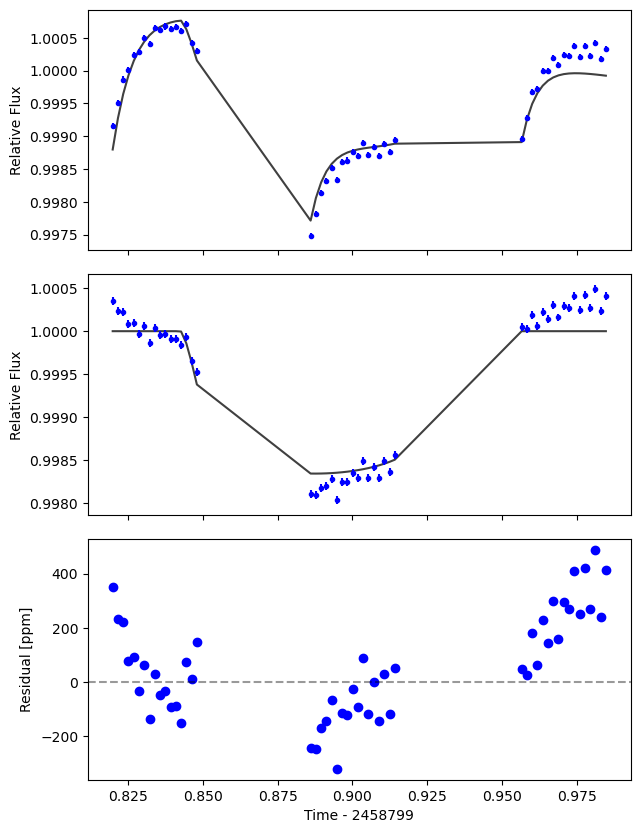

In [32]:
## Looking at the initial starting model
transit_model_start = transit(theta_init, BATMAN_initmodel)
hook_model_start = hook(theta_init, t_orbit)
ramp_model_start = ramp(theta_init, t_visit)
sys_model_start = hook_model_start * ramp_model_start
model_start = transit_model_start * sys_model_start
detflux_start = fluxes / sys_model_start
residuals_start = fluxes - model_start

print('Initial model -------')
lnL_init = logLikelihood(fluxes, errors, model_start)
lnP_init = lnPosterior(theta_init, times, t_visit, t_orbit, fluxes, errors, priors, priorserr)
print('ln Likelihood = ', lnL_init)
print('ln Posterior = ', lnP_init)

fig, ax = plt.subplots(figsize=(7,10), nrows=3, sharex=True)
plt.subplots_adjust(hspace=0.1)
# uncorrected flux and model
ax[0].plot(times-2458799, model_start, c='black', alpha=0.75)
ax[0].errorbar(times-2458799, fluxes, errors, ls='None', marker='o', c='blue', ms=3)
ax[0].set_ylabel('Relative Flux')
# detrended flux and transit model
ax[1].plot(times-2458799, transit_model_start, c='black', alpha=0.75)
ax[1].errorbar(times-2458799, detflux_start, errors, ls='None', marker='o', c='blue', ms=3)
ax[1].set_ylabel('Relative Flux')
# residuals
ax[2].axhline(0., c='black', ls='--', alpha=0.4)
ax[2].scatter(times-2458799, residuals_start*1.e6, c='blue')
ax[2].set_ylabel('Residual [ppm]')
ax[2].set_xlabel('Time - 2458799')
plt.show()

In [33]:
######################################
# Setting up and initializing MCMC

Ndimensions = len(theta_init)
Nwalkers = 3*Ndimensions
burn = 5000
Nsteps = 30000 + burn

# Initializing walker positions
pos = np.zeros((Nwalkers, Ndimensions))
try:
    # if we ran this before, initialize based on previous run's best fits
    for i in range(Ndimensions):
        pos[:,i] = param_fits[i] + 0.5*np.random.normal(0., param_uperrs[i], Nwalkers)
except:
    # if not, then use theta_init array
    for i in range(Ndimensions):
        pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)

In [35]:
with Pool() as pool: 
    sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool, 
                                 args=(times, t_visit, t_orbit, fluxes, errors, priors, priorserr))
    sampler.run_mcmc(pos, Nsteps, progress=True);

100%|██████████| 35000/35000 [01:59<00:00, 292.36it/s]


In [40]:
samples = sampler.get_chain()
flatsamples = sampler.get_chain(flat=True)
loglikelihoods = sampler.get_log_prob(flat=True)
#autocorrtimes = sampler.get_autocorr_time()


samples = samples[burn:]
flatsamples = flatsamples[burn*Nwalkers:]
loglikelihoods = loglikelihoods[burn*Nwalkers:]

param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

# Generating models with best-fit parameters
bf_transit = transit(param_fits, BATMAN_initmodel)
bf_hook = hook(param_fits, t_orbit)
bf_ramp = ramp(param_fits, t_visit)
bf_sys = bf_hook * bf_ramp
bf_model = bf_transit * bf_sys

detflux = fluxes / bf_sys
deterrs = errors / bf_sys

# Generating a smooth transit light curve with best-fit parameters for plotting purposes
times_smooth = np.linspace(times[0], times[-1], 100)
BFParams = batman.TransitParams()
BFParams.t0 = param_fits[0]      
BFParams.per = 10.**param_fits[1]
BFParams.a = 10.**param_fits[2]
BFParams.inc = np.arccos(param_fits[3])*(180./np.pi)
BFParams.rp = param_fits[4]
BFParams.ecc = 0.
BFParams.w = 90.
BFParams.limb_dark = 'quadratic'
BFParams.u = [0.33, 0.2]
BATMAN_smoothmodel = batman.TransitModel(BFParams, times_smooth)
transit_smooth = transit(param_fits, BATMAN_smoothmodel)

In [37]:
# fig, axes = plt.subplots(samples.shape[2], figsize=(14,15), sharex=True)
# for i in range(samples.shape[2]):
#     ax = axes[i]
#     ax.plot(samples[:,:,i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.axhline(priors[i], c='blue', ls='--', alpha=0.5)
    
# axes[0].set_title('Parameter Chains with %d step burn-in and %d total steps'%(burn, Nsteps))
# axes[-1].set_xlabel('Steps')
# plt.savefig('figures/HSTbroadbandfit_chains.png', dpi=300, bbox_inches='tight')
# plt.show()

In [23]:
#cornerfig = corner.corner(flatsamples, labels=labels, show_titles=True)
#plt.show()

In [46]:
headers = ["Fit Value", "Upper error", "Lower error"]
l = []
for i, val in enumerate(labels):
    new = [labels[i], param_fits[i], param_uperrs[i], param_loerrs[i]]
    l.append(new)
    
from tabulate import tabulate    
table = tabulate(l, headers, tablefmt='orgtbl')
print('Best-Fit Fitting Parameters')
print(table)

## Computing derived parameters
# transit depth
tdepth_chain = flatsamples[:,4]**2
tdepth_fit = np.median(tdepth_chain)
tdepth_uperr = np.percentile(tdepth_chain, 84) - tdepth_fit
tdepth_loerr = tdepth_fit - np.percentile(tdepth_chain, 16)
# period [day]
P_chain = 10.**(flatsamples[:,1])
P_fit = np.median(P_chain)
P_uperr = np.percentile(P_chain, 84) - P_fit
P_loerr = P_fit - np.percentile(P_chain, 16)

derived_labels = np.asarray(['depth', 'P'])
dp_fits = np.asarray([tdepth_fit*1.e6, P_fit])
dp_uperrs = np.asarray([tdepth_uperr*1.e6, P_uperr])
dp_loerrs = np.asarray([tdepth_loerr*1.e6, P_loerr])
dl = []
for i, val in enumerate(derived_labels):
    dl.append([derived_labels[i], dp_fits[i], dp_uperrs[i], dp_loerrs[i]])
print('Derived Parameters')
table2 = tabulate(dl, headers, tablefmt='orgtbl')
print(table2)

## error statistics
print('Error Statistics')
residuals = fluxes - bf_model
mean_residual, sd_residual = norm.fit(residuals)
mean_abs_residual = np.mean(abs(residuals))
print('Mean Residual = %.2f ppm'%(mean_abs_residual*1.e6))
print('Residual scatter = %.2f ppm'%(sd_residual*1.e6))
mean_dataerr = np.mean(errors)
print('Mean Data Error = %.2f ppm'%(mean_dataerr*1.e6))
mean_deterr = np.mean(deterrs)
print('Mean Detrended Error = %.2f ppm'%(mean_deterr*1.e6))
bf_lnPost = lnPosterior(param_fits, times, t_visit, t_orbit, fluxes, errors, priors, priorserr)
print('Best Fit lnPosterior = ', bf_lnPost)

Best-Fit Fitting Parameters
|           |    Fit Value |   Upper error |   Lower error |
|-----------+--------------+---------------+---------------|
| tc        |  2.45833e+06 |   0.00099363  |   0.000959859 |
| log10P    |  0.780639    |   7.37149e-07 |   7.24988e-07 |
| log10a    |  1.12146     |   0.0088568   |   0.00871271  |
| cosi      |  0.0632946   |   0.00188644  |   0.00189737  |
| RpRs      |  0.0431492   |   0.000452331 |   0.000438135 |
| amp1      |  0.00165113  |   4.53359e-05 |   4.44156e-05 |
| amp2      |  0.00139612  |   2.93223e-05 |   2.93031e-05 |
| tau1      | -0.00652447  |   0.000441581 |   0.000508635 |
| tau2      | -0.00571678  |   0.000272438 |   0.000287008 |
| slope     | -0.00304526  |   0.000258537 |   0.000278594 |
| intercept |  1.0008      |   4.00845e-05 |   3.5766e-05  |
Derived Parameters
|       |   Fit Value |   Upper error |   Lower error |
|-------+-------------+---------------+---------------|
| depth |  1861.85    |  39.24        |  37.6184

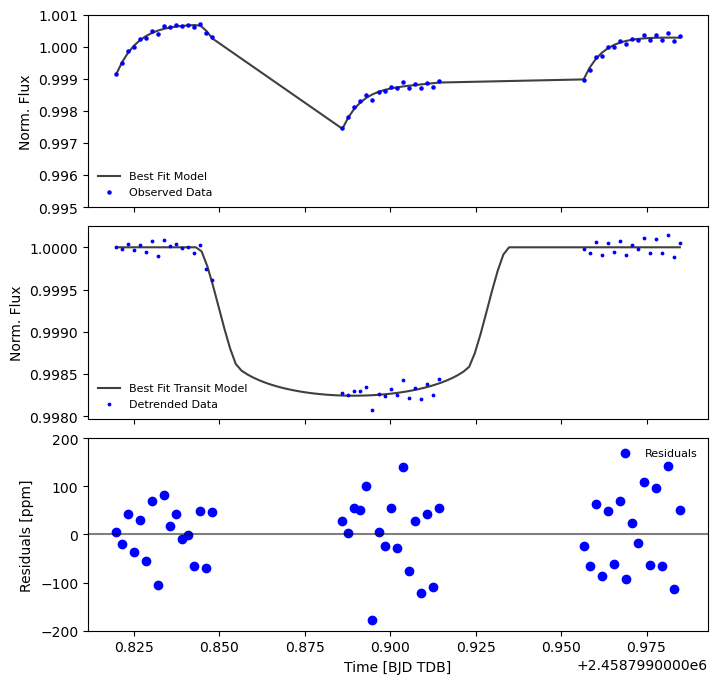

In [42]:
# bf_lnPost = lnPosterior(param_fits)
# print('ln Posterior values:')
# print('init = ', lnPost_init)
# print('best fit = ', bf_lnPost)
# #print('ratio = ', abs(bf_lnPost)/abs(lnPost_init))

# print('error statistics')
# print('mean detrended uncertainty = ', 1.e6*np.mean(deterrs), ' ppm')

# print('mean absolute residual = ', 1.e6*np.mean(abs(residuals)), ' ppm')

fig, ax = plt.subplots(figsize=(8, 8), nrows=3, sharex=True)
plt.subplots_adjust(hspace=0.1)
ax[0].plot(times, bf_model, c='black', alpha=0.75, label='Best Fit Model')
ax[0].scatter(times, fluxes, c='blue', zorder=5, s=5, label='Observed Data')
ax[0].legend(loc='best', fontsize=8, frameon=False)
ax[0].set_ylim(0.995, 1.001)
ax[0].set_ylabel('Norm. Flux')

ax[1].plot(times_smooth, transit_smooth, c='black', alpha=0.75, label='Best Fit Transit Model')
ax[1].scatter(times, detflux, c='blue', zorder=5, s=3, label='Detrended Data')
ax[1].legend(loc='best', fontsize=8, frameon=False)
ax[1].set_ylabel('Norm. Flux')

ax[2].scatter(times, residuals*1.e6, c='blue', label='Residuals')
ax[2].axhline(0., c='black', alpha=0.5)
ax[2].set_ylabel('Residuals [ppm]')
ax[2].set_ylim(-200, 200)
ax[2].set_xlabel('Time [BJD TDB]')
ax[2].legend(loc='best', fontsize=8, frameon=False)

plt.show()